In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import pycolmap

from megadepth.metrics.metadata import collect_metrics

In [3]:
def plot_images(images: list, titles: list, dimension: tuple) -> None:
    fig = plt.figure(figsize=(30, 30))

    for i in range(dimension[0]):
        for j in range(dimension[1]):
            idx = 1 + j + (i * dimension[1])
            fig.add_subplot(dimension[0], dimension[1], idx)
            plt.axis("off")
            plt.imshow(images[idx-1])
            plt.title(titles[idx-1])
 
    plt.show()

In [4]:
base = "../data/scenes"
scene = "0229"
retrieval_model = "netvlad-50"
full_model = "superpoint_max-superglue"
# full_model += ("-" if not retrieval_model=="" else "") + retrieval_model
# full_model = "superpoint_max-superglue"
image_dir = os.path.join(base, scene, "images")

In [5]:
img_names = [
    img for img in os.listdir(os.path.join(base, scene, "images")) 
    if img.endswith(".jpg") or img.endswith(".JPG") or img.endswith(".png")
]

In [6]:
reconstruction = pycolmap.Reconstruction(os.path.join(base, scene, "sparse", full_model))
images = reconstruction.images
cameras = reconstruction.cameras

In [7]:
r_img_names = []
for key in images.values():
    r_img_names.append(key.name)

In [8]:
retrievals = pd.read_table(os.path.join(base, scene, "matches", "retrieval", retrieval_model + ".txt"), sep=" ", names=["from", "to"])

In [9]:
res = pd.crosstab(retrievals["from"], retrievals["to"])
res = res.reindex(index = img_names, columns = img_names, fill_value = 0)

In [10]:
retrieval_scores = res.sum(axis = 0) / len(img_names)

In [11]:
diff = np.setdiff1d(img_names, r_img_names)
diff_mask = retrieval_scores.index.isin(diff)

In [12]:
retrieval_scores

to
10144932045_90ec4fc1b3_o.jpg    0.614824
101990823_a03c914b24_o.jpg      0.652491
102436821_ce371d1876_o.jpg      0.204131
10301885064_643862f620_o.jpg    0.851762
10767341414_8de553bc34_o.jpg    0.622114
                                  ...   
9600456216_6014e1af63_b.jpg     0.436209
9628624063_b708f984ab_b.jpg     0.947752
9737429066_d298b78f33_b.jpg     0.823815
9785340164_7db25f1f2a_o.jpg     0.482382
9844599833_e305272d0b_o.jpg     0.613609
Length: 823, dtype: float64

In [13]:
retrieval_scores[diff_mask].mean()

0.5077326191716055

In [14]:
retrieval_scores = retrieval_scores.sort_values()
diff_mask = retrieval_scores.index.isin(diff)

In [15]:
retrieval_scores = pd.concat([retrieval_scores[~diff_mask], retrieval_scores[diff_mask]])
diff_mask = retrieval_scores.index.isin(diff)

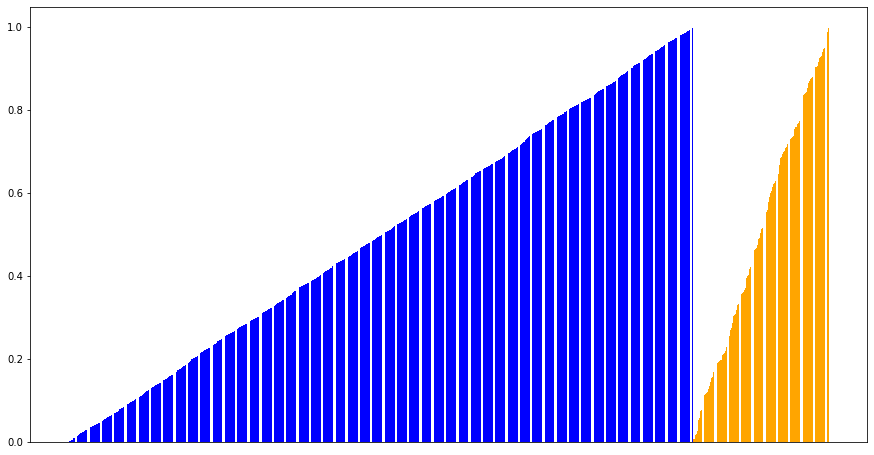

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.bar(retrieval_scores.index, retrieval_scores.values, color=["orange" if idx==True else "blue" for idx in diff_mask])
plt.show()

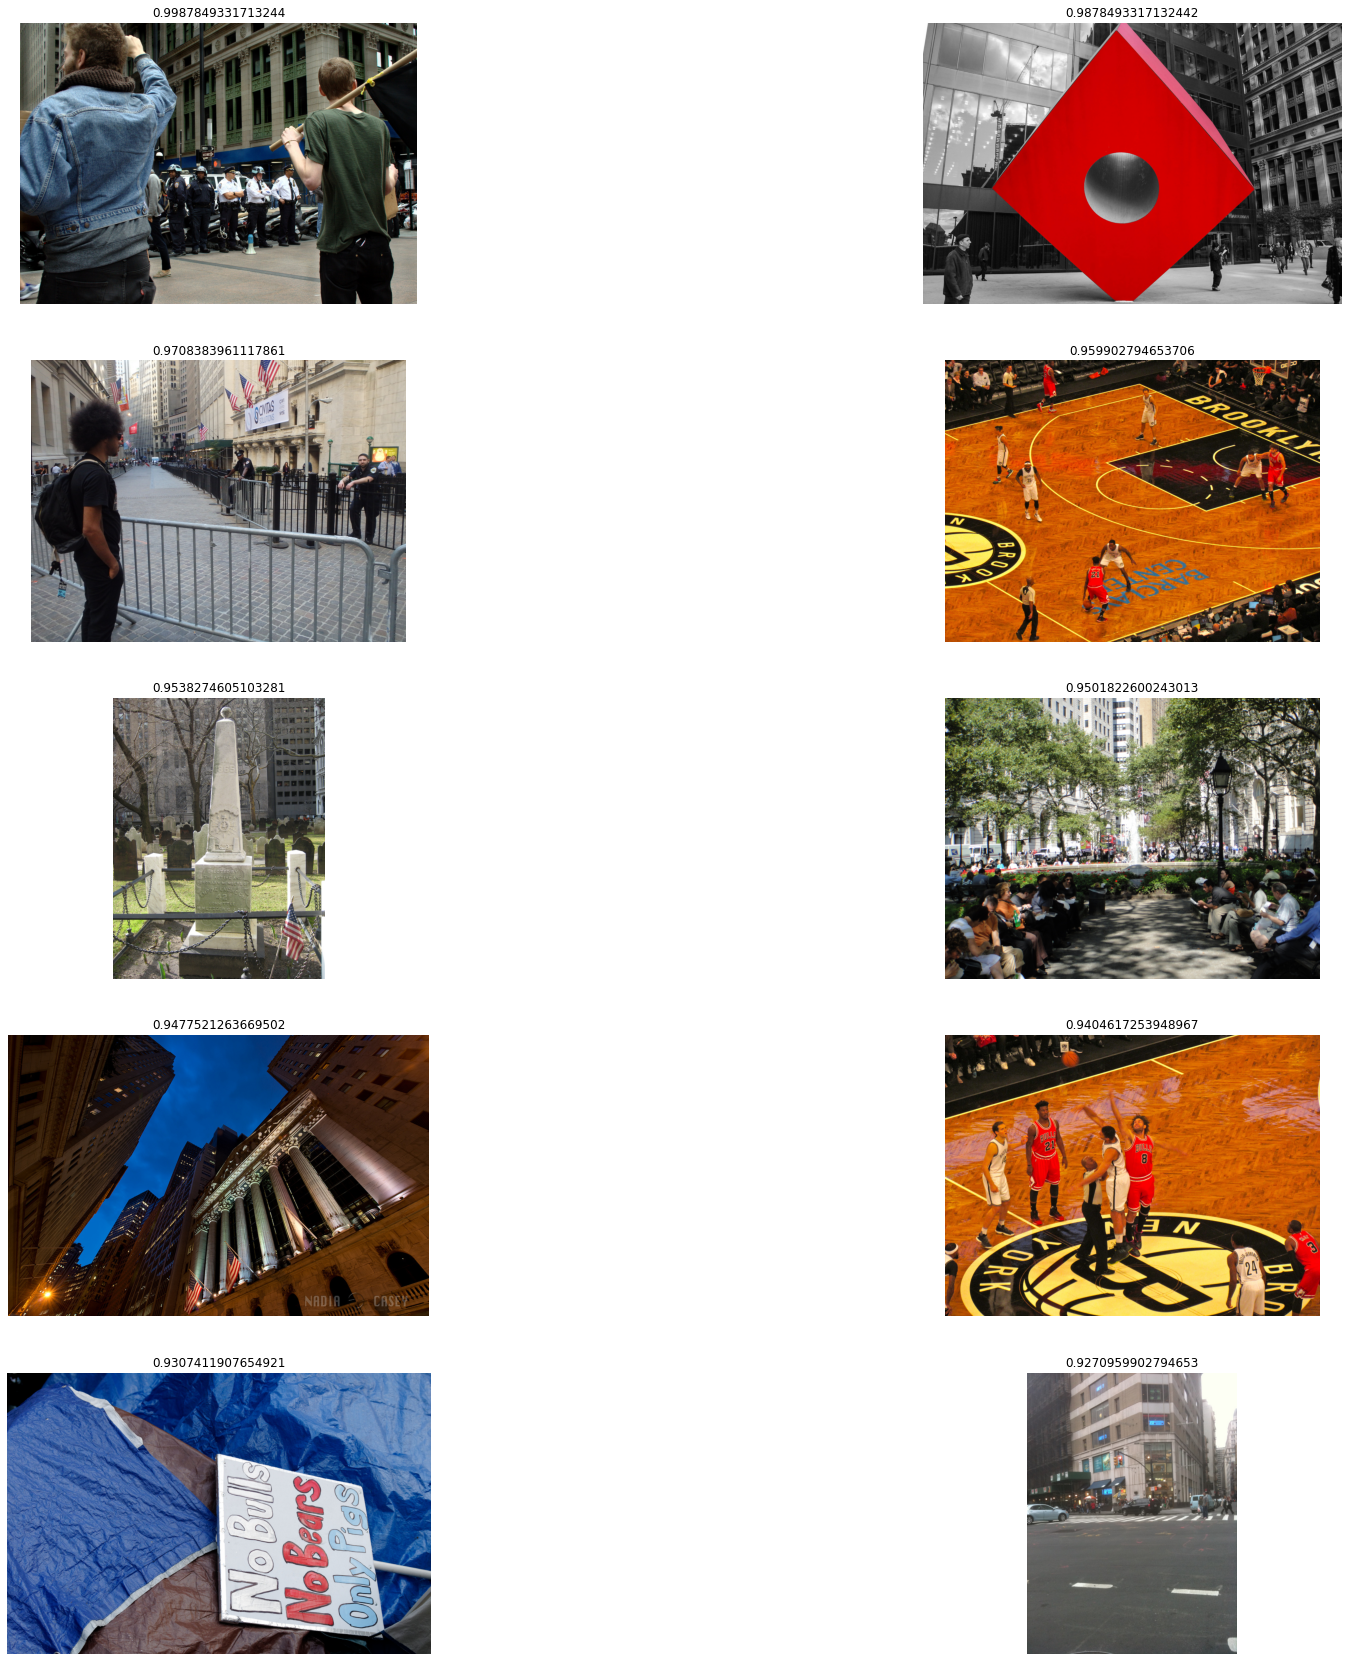

In [17]:
colors = []
labels = []
for index, value in retrieval_scores[diff_mask].nlargest(10).items():
    colors.append(imread(os.path.join(image_dir, index)))
    labels.append(value)
    
plot_images(colors, labels, (5, 2))

In [20]:
query_img = retrieval_scores[diff_mask].idxmax()
all = pd.concat([retrievals[retrievals["to"]==query_img]])
all

from                           to
821     20478883340_d02a06fdbe_o.jpg  6160993730_1f549b61f8_o.jpg
1642      290928491_0ce26955d4_o.jpg  6160993730_1f549b61f8_o.jpg
2462     2607575481_44852cab9d_o.jpg  6160993730_1f549b61f8_o.jpg
3281     2896956020_e4c281f990_b.jpg  6160993730_1f549b61f8_o.jpg
4099     3658570023_1a4499a34d_o.jpg  6160993730_1f549b61f8_o.jpg
...                              ...                          ...
338242  12550239643_9c43d41e56_o.jpg  6160993730_1f549b61f8_o.jpg
338246   6228395055_cc5cba034d_b.jpg  6160993730_1f549b61f8_o.jpg
338249   6751900051_ab3157c1f4_o.jpg  6160993730_1f549b61f8_o.jpg
338251    477699948_f84b8189df_o.jpg  6160993730_1f549b61f8_o.jpg
338252   6010660937_e68eb044bf_b.jpg  6160993730_1f549b61f8_o.jpg

[822 rows x 2 columns]

Unregistered image with largest number of retrieval associations

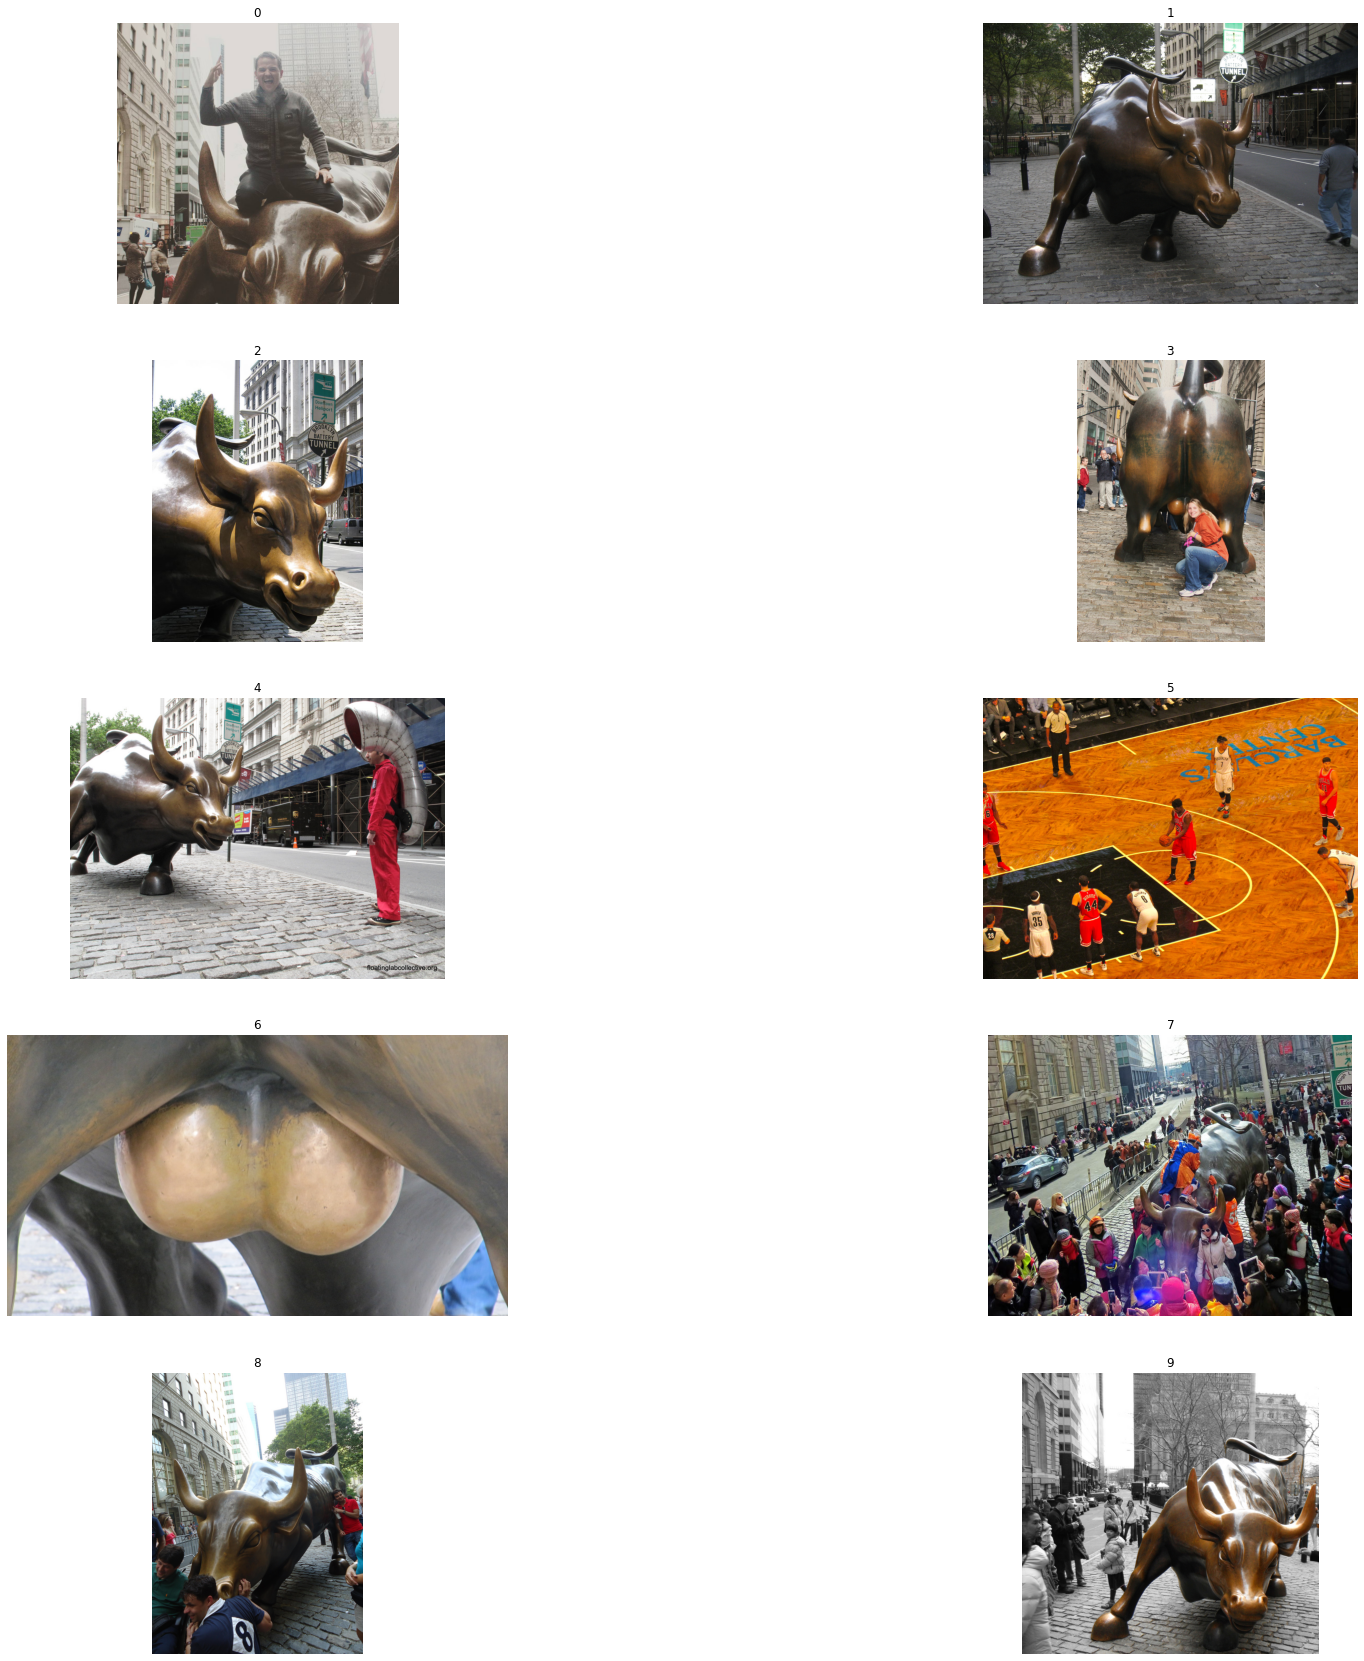

In [24]:
colors = []
labels = []
for image in all.iloc[:10, 0]:
    colors.append(imread(os.path.join(image_dir, image)))

labels = np.arange(len(colors))

plot_images(colors, labels, (5, 2))